In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
engine = create_engine(r"sqlite:///Resources/hawaii.sqlite")

In [4]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [5]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [6]:
# Get a list of column names and types for stations table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
columns = inspector.get_pk_constraint('station')
columns

{'constrained_columns': ['id'], 'name': None}

In [8]:
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/zs/hh5swvp55_sc2db9q_cg1c340000gn/T/ipykernel_10783/2162511228.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [9]:
Base.classes.keys()

['station', 'measurement']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
session = Session(engine)

In [12]:
# Exploratory Climate Analysis

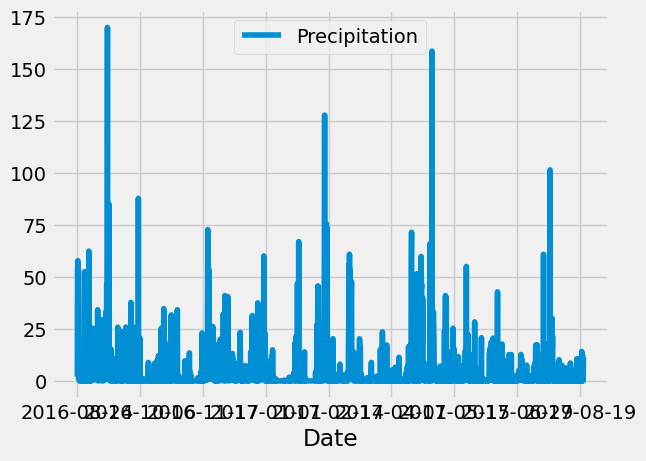

In [15]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

# Calculate the date 1 year ago from the last data point in the database
last_year = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores (working with actual data)
rain_results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column 
precipitation_df = pd.DataFrame(rain_results, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)
precipitation_df = precipitation_df.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation_df.plot().get_figure()
ax.savefig("Precipitation_last_12months.png")

In [16]:
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,4.485112
std,11.690532
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


In [17]:
locations = session.query(Station)
print("There are {} stations.".format(locations.count()))

There are 9 stations.


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations_descending = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

most_active_station_name = ""
most_active_station = active_stations_descending[0][0]

for location in locations:
    if(location.station == active_stations_descending[0][0]):
        most_active_station_name = location.name
print(f"The most active stations information is as follows: ")
print(f" Name    : {most_active_station_name} ")
print(f" Station : {active_stations_descending[0][0]}")
print(f" Count   : {active_stations_descending[0][1]}")
print("")
print("List of the stations and the counts in descending order:")
print("Station        Counts")
print("-----------------------")
for active_station_descending in active_stations_descending:
    print(active_station_descending[0], "   ", active_station_descending[1])

The most active stations information is as follows: 
 Name    : WAIHEE 837.5, HI US 
 Station : USC00519281
 Count   : 2772

List of the stations and the counts in descending order:
Station        Counts
-----------------------
USC00519281     2772
USC00519397     2724
USC00513117     2709
USC00519523     2669
USC00516128     2612
USC00514830     2202
USC00511918     1979
USC00517948     1372
USC00518838     511


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature most active station?
temperature_frequencies = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print(f"The Lowest, Highest & the average temperature for most active station {most_active_station} is :")
print(f" Low  : {temperature_frequencies[0][0]}")
print(f" High : {temperature_frequencies[0][1]}")
print(f" Avg  : {temperature_frequencies[0][2]}")

The Lowest, Highest & the average temperature for most active station USC00519281 is :
 Low  : 12.2
 High : 29.4
 Avg  : 22.03582251082252


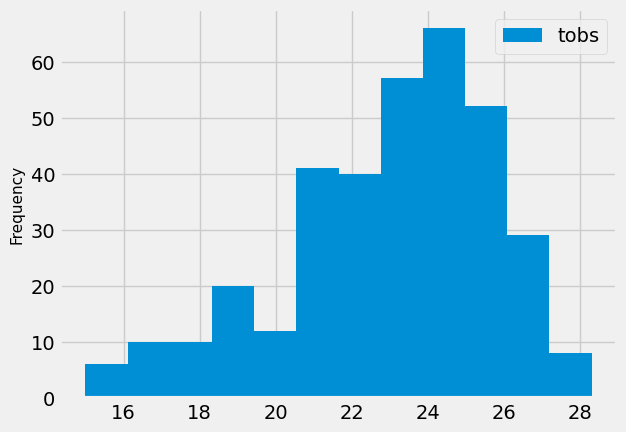

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).filter(Measurement.date >= last_year).\
    group_by(Measurement.date).all()

# Put data into dataframe so it can be plotted as histogram
temp_results_df = pd.DataFrame(data=temp_results, columns=["date", "tobs"])
temp_results_df = temp_results_df.set_index('date', drop=True)

#Plot the results as a histogram with bins=12
plt.hist(temp_results_df['tobs'],12, label="tobs")
plt.ylabel("Frequency", fontsize=11)
plt.legend()
plt.savefig("Temperature_for_active station_last_12months.png")
plt.show()

In [21]:
def calc_temps(start_date, end_date):
    select = [Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*select).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [22]:
trip_arrive = dt.date(2018, 4, 1)
trip_leave = dt.date(2018, 4, 15)
last_year = dt.timedelta(days=365)

# calculate the min/max/avg from last year that matches my trip date
data = calc_temps((trip_arrive-last_year), (trip_leave-last_year))

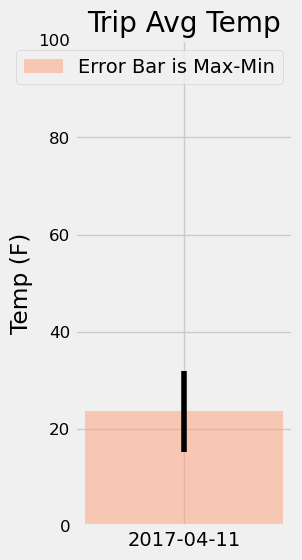

In [23]:
bar_trip_df = pd.DataFrame(data=data, columns=["date","tmin", "tavg", "tmax"])
bar_trip_df = bar_trip_df.set_index('date', drop=True)

#Create variables for my plot
plot_date = bar_trip_df.index.values
plot_tmin = bar_trip_df['tmin']
plot_tavg = bar_trip_df['tavg']
plot_tmax = bar_trip_df['tmax']

# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
diff = bar_trip_df['tmax'] - bar_trip_df['tmin']
plt.figure(figsize=[2.5, 6])
pavg = plt.bar(plot_date, plot_tavg, yerr=diff, color="lightsalmon", alpha=.5, label="Error Bar is Max-Min")
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.legend()
plt.yticks(np.arange(0, 120, 20), fontsize=12)
plt.savefig("Bar_MyTrip_Avg_Temp.png")
plt.show()

In [24]:
#### ------------------------ OPTIONAL PART - 2 -----------------------------------------------------------
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
lst_year_arrive = trip_arrive - last_year
lst_year_leave = trip_leave - last_year

results = session.query(Station.station,
                  func.sum(Measurement.prcp),
                  Station.name,
                  Station.latitude,
                  Station.longitude,
                  Station.elevation)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= lst_year_arrive)\
.filter(Measurement.date <= lst_year_leave)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())

# A nice layout to read the results
print (f"Historical Rainfall Per Weather Station - Descending order")
print(f"Trip Dates: {trip_arrive} - {trip_leave}")
print(f"Most Recent Data Search Dates: {lst_year_arrive} - {lst_year_leave}")
print()
for row in results:
    rain = "{0:.2f}".format(row[1])
    print (f"Station:  {row[0]}\n    Rainfall:  {rain}  \n    Location:  {row[2]}\n    Latitude:  {row[3]}  \
    Longitude:  {row[4]}  Elevation:  {row[5]}")
    print()

Historical Rainfall Per Weather Station - Descending order
Trip Dates: 2018-04-01 - 2018-04-15
Most Recent Data Search Dates: 2017-04-01 - 2017-04-15

Station:  USC00516128
    Rainfall:  146.00  
    Location:  MANOA LYON ARBO 785.2, HI US
    Latitude:  21.3331      Longitude:  -157.8025  Elevation:  46.449

Station:  USC00519281
    Rainfall:  105.20  
    Location:  WAIHEE 837.5, HI US
    Latitude:  21.45167      Longitude:  -157.84889  Elevation:  10.027

Station:  USC00513117
    Rainfall:  41.70  
    Location:  KANEOHE 838.1, HI US
    Latitude:  21.4234      Longitude:  -157.8015  Elevation:  4.45

Station:  USC00514830
    Rainfall:  23.00  
    Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
    Latitude:  21.5213      Longitude:  -157.8374  Elevation:  2.133

Station:  USC00519523
    Rainfall:  9.10  
    Location:  WAIMANALO EXPERIMENTAL FARM, HI US
    Latitude:  21.33556      Longitude:  -157.71139  Elevation:  5.943

Station:  USC00519397
    Rainfall:  6.90  
    L

In [25]:
# Create a query that will calculate the daily normals
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
def daily_normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

daily_normals("01-01")

[(16.7, 20.64230769230769, 25.0)]

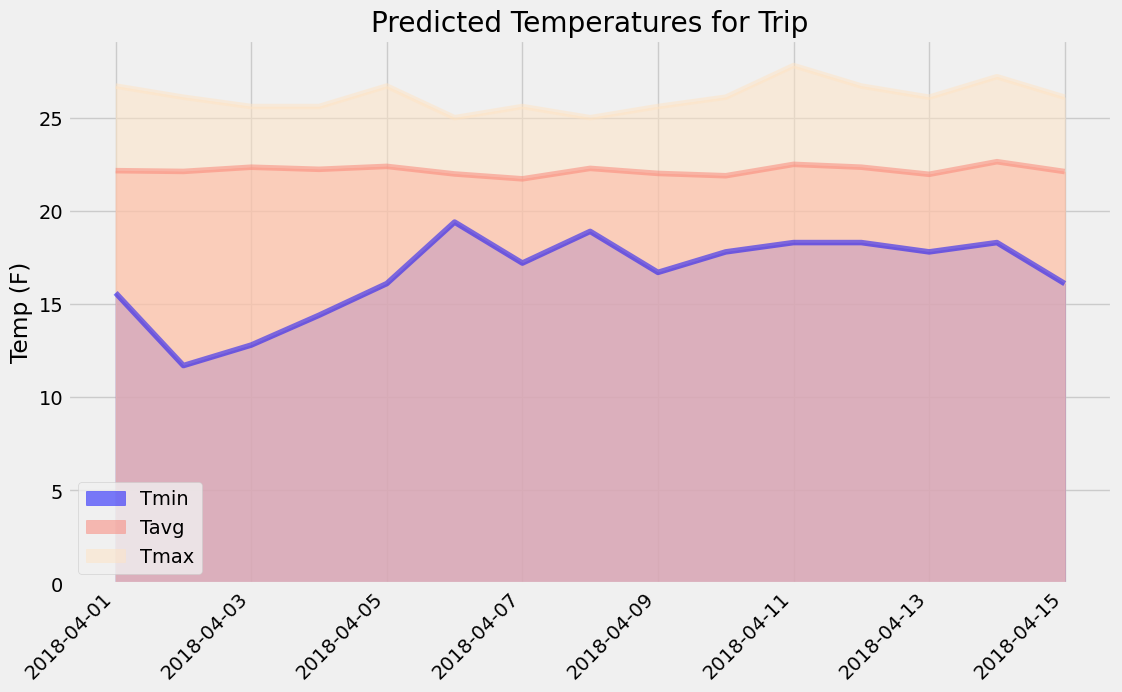

In [26]:
# create a list of dates for your trip
trip_dates = pd.date_range(trip_arrive, trip_leave)

# format it to %m-%d
trip_mmdd = trip_dates.strftime('%m-%d')

# calculate the normals for each date string and append the results to a list
normals_list = []
for trip_date in trip_mmdd:
    # call daily_normals function to return the tuple list
    normals_list.append(*daily_normals(trip_date))

# make a normal df from the normals list
normals_df = pd.DataFrame(normals_list, columns = ['Tmin', 'Tavg', 'Tmax'])
# make the trip dates the index
normals_df['Date'] = trip_dates
normals_df = normals_df.set_index('Date')

# Now plot the results
# the colors list
colors = ['blue', 'salmon', 'bisque']

normals_df.plot(kind='area', figsize=(12, 8), stacked=False, x_compat=True, color=colors, alpha=.5, title='Predicted Temperatures for Trip', rot=45)
plt.xlabel('')
plt.ylabel('Temp (F)')
plt.savefig("Predicted_Temperatures_for_Trip.png")
plt.show()